In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!rm setup/nvcc-path.sh

In [108]:
!pip install open3d 1>/dev/null
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!git pull
from datasets.shapenet_data_pc import ShapeNet15kPointClouds
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
dataset = ShapeNet15kPointClouds(root_dir=shapenet_location, tr_sample_size=2048, te_sample_size=2048)
from metrics.chamfer_distance import np_chamfer_distance
from visuals.visuals_util import visualize_pointcloud_eval, visualize_pointcloud_eval_three, visualize_pointcloud
from utils.nearest_neighbor import get_nearest_neighbors_batch_pytorch3d
from utils.random_noise import add_random_noise

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), 3.29 MiB | 2.79 MiB/s, done.
From https://gitlab.lrz.de/00000000014A00FC/coarse-to-fine-shapes
   0341ba1..5a54647  main       -> origin/main
Updating 0341ba1..5a54647
Fast-forward
 eval-results/data-for-visualization/global-refinement-input.pth | Bin 0 -> 492267 bytes
 .../data-for-visualization/global-refinement-noised-input.pth   | Bin 0 -> 492267 bytes
 .../data-for-visualization/global-refinement-output.pth         | Bin 0 -> 492267 bytes
 train_PVCNN_Reconstruction-Noise-Patch.ipynb                    |  77 ++++++++++++++++++++++++----
 train_PVCNN_Reconstruction-Noise.ipynb                          |  37 ++++++++-----
 utils/random_noise.py                                           |   2 +-
 6 files

In [ ]:
import torch
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,
                                          batch_size=10,
                                          sampler=None,
                                          shuffle=True is None,
                                          num_workers=1,
                                          drop_last=True)


In [ ]:
for batch in dataloader:
    input = batch["train_points"]
    break

In [ ]:
print(input.shape)

torch.Size([10, 2048, 3])


In [ ]:
patched_batch = get_nearest_neighbors_batch_pytorch3d(input, 511)

In [ ]:
print(patched_batch.shape)

torch.Size([10, 512, 3])


In [ ]:
def add_random_noise(point_cloud, mean=0, std=0.025):
    noise = torch.normal(mean, std, size=point_cloud.size())
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

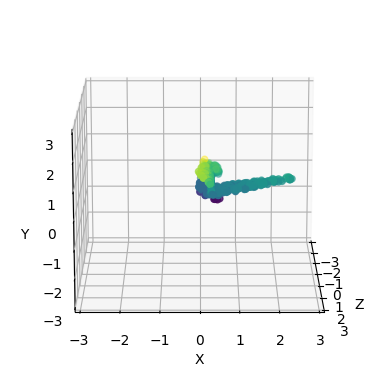

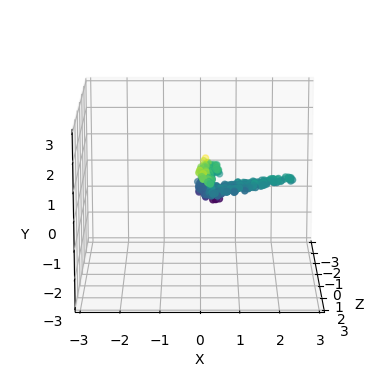

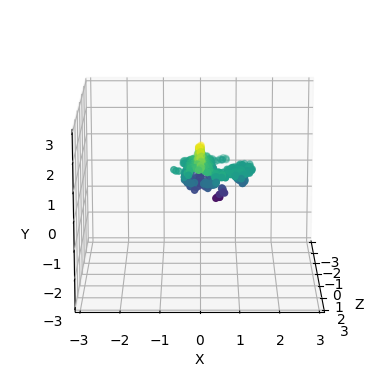

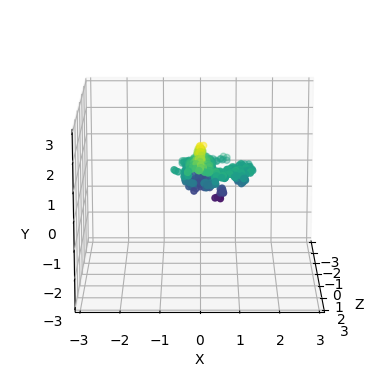

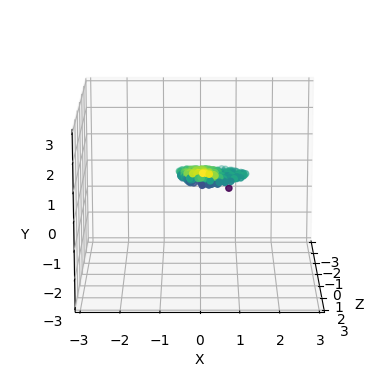

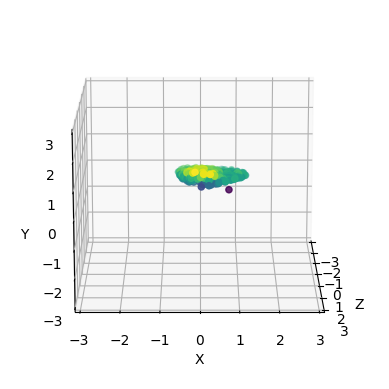

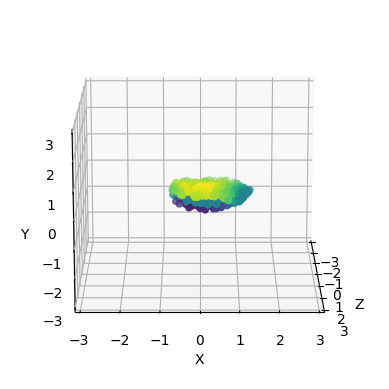

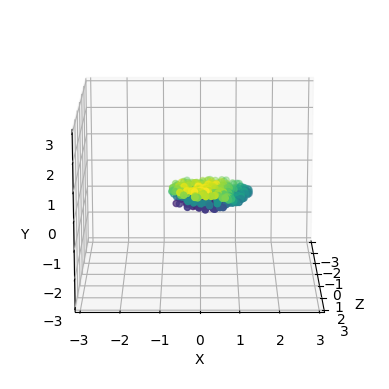

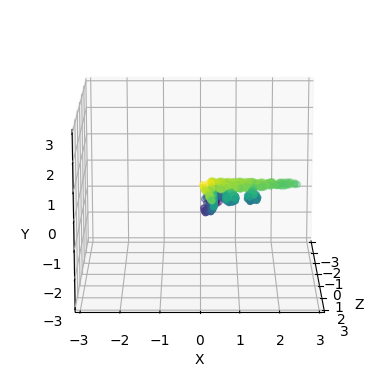

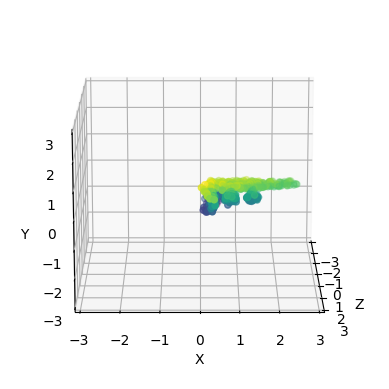

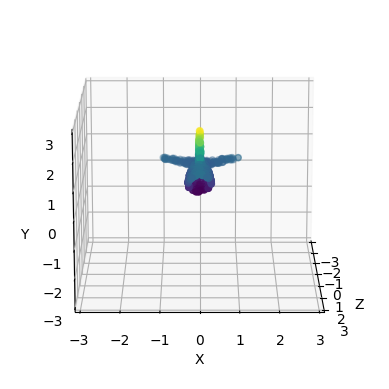

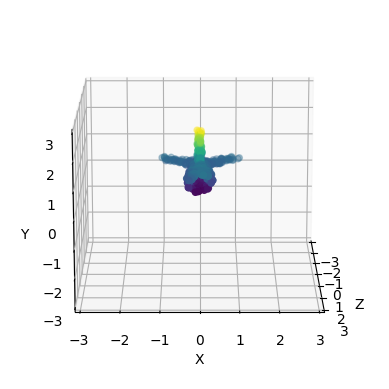

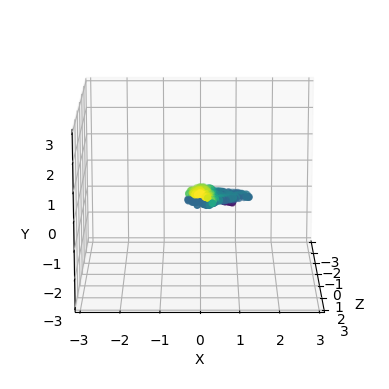

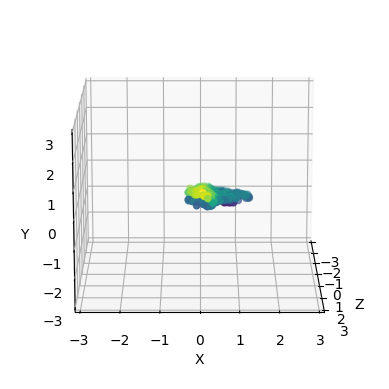

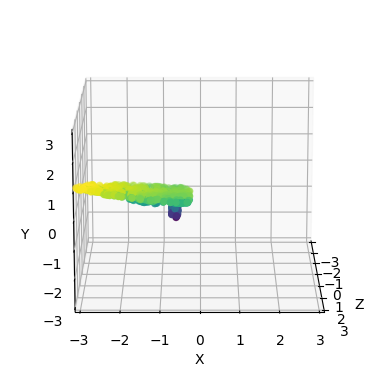

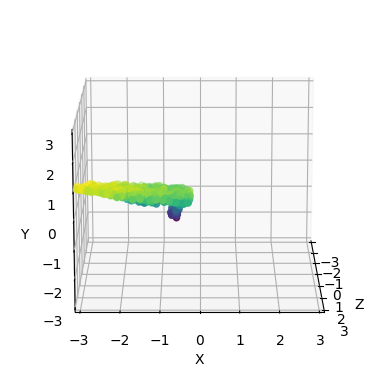

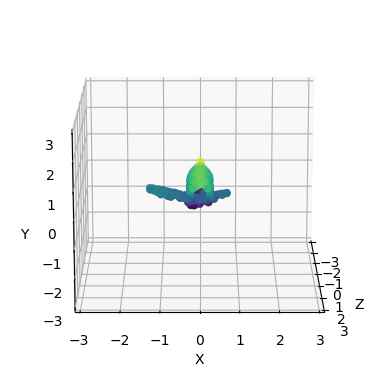

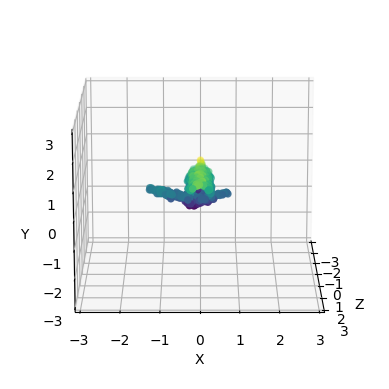

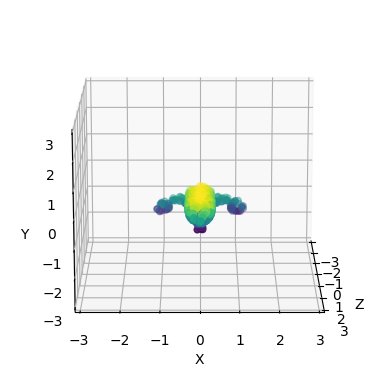

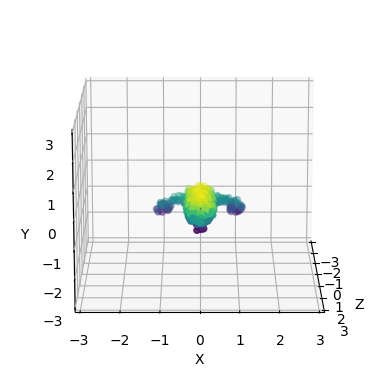

In [71]:
for sample in patched_batch:
  visualize_pointcloud(sample.squeeze(), axis_ranges=[[-3, 3] for i in range(3)])
  visualize_pointcloud(add_random_noise(sample.squeeze()), axis_ranges=[[-3, 3] for i in range(3)])

torch.Size([512, 3])
torch.Size([512, 3])


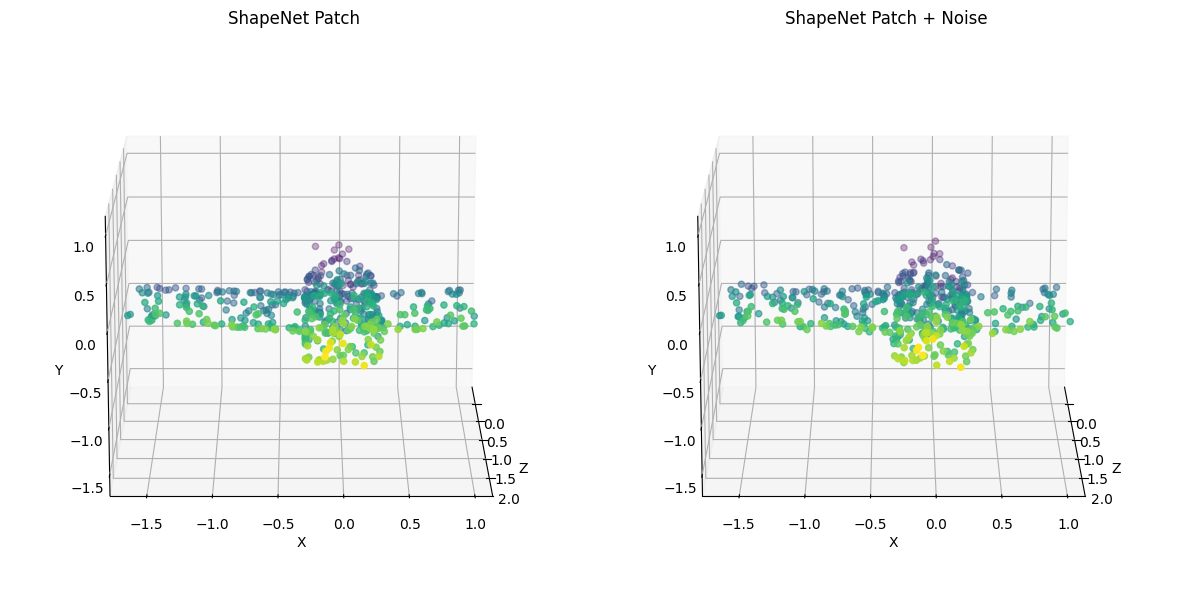

In [ ]:
i = 1
sample = patched_batch[0]
print(sample.shape)
input_np = sample.squeeze()
print(input_np.shape)
noisy_input = add_random_noise(input_np)
fig = visualize_pointcloud_eval(input_np, noisy_input, title1="ShapeNet Patch", title2="ShapeNet Patch + Noise")

In [98]:
shapenet_airplane = torch.load("shapenet_airplane_pvd_closest_neighbour.pth")['train_points']
noisy_shapenet_airplane = add_random_noise(shapenet_airplane)
pvd_airplane = torch.load("pvd_output/airplane_pc_data.pth", map_location=torch.device('cpu'))[26]

tensor([[[ 1.7381, -0.1301,  0.2048]],

        [[-1.7719,  0.1041,  0.1468]],

        [[-0.3833, -0.0498, -0.3051]]])


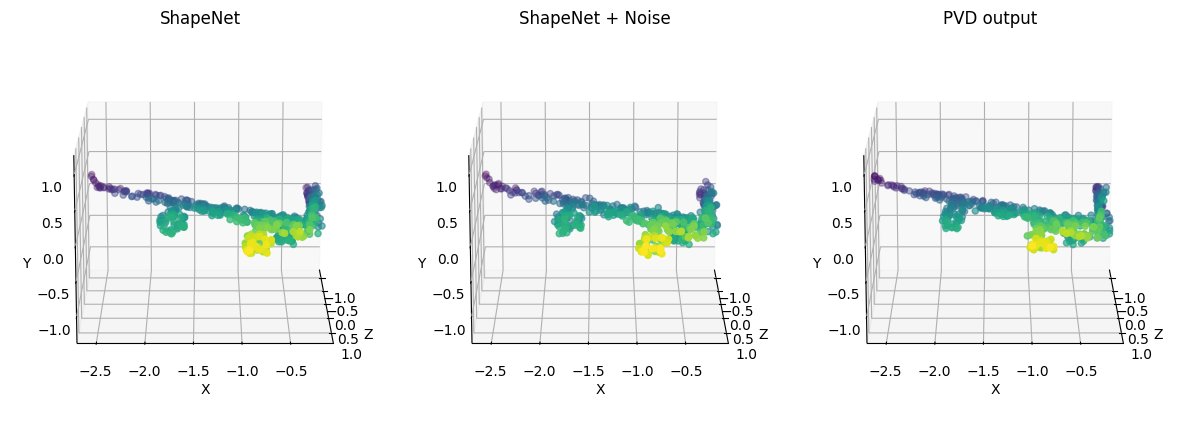

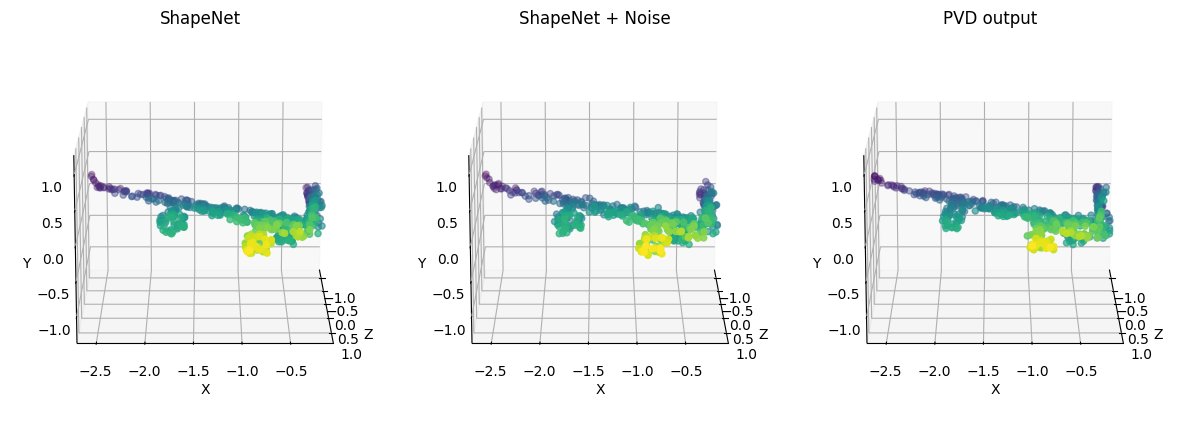

In [107]:
from pytorch3d.ops import knn_points

batch = torch.stack([shapenet_airplane, noisy_shapenet_airplane, pvd_airplane])
N = 511

batch_size, num_points, _ = batch.shape

# Select a random point from each point cloud in the batch
indices = torch.tensor([300, 200, 200]).to(batch.device)
selected_points = batch[torch.arange(batch_size), indices].unsqueeze(1)
print(selected_points)
selected_points[1] = selected_points[0]
selected_points[2] = selected_points[0]


# Use knn from PyTorch3D
knn_result = knn_points(selected_points, batch, K=N)

nn_idx = knn_result.idx.squeeze()

# Add an extra dimension to selected_points to make it [20, 255, 1]
selected_points_expanded = nn_idx.unsqueeze(-1)

# Expand selected_points to match the last dimension of input_tensor
selected_points_expanded = selected_points_expanded.expand(-1, -1, batch.shape[-1])

# Gather the points from the input_tensor
result = torch.gather(batch, 1, selected_points_expanded)

result = torch.cat([result, selected_points], dim=1)

visualize_pointcloud_eval_three(result[0], result[1], result[2], title1="ShapeNet", title2="ShapeNet + Noise", title3="PVD output")